In [1]:
%pip install altair pandas plotly pygal cairosvg ruamel.yaml PrefixedUnit networkx

ERROR: Could not find a version that satisfies the requirement PrefixedUnit (from versions: none)
ERROR: No matching distribution found for PrefixedUnit
Note: you may need to restart the kernel to use updated packages.


In [61]:
import pandas as pd
import altair as alt
import numpy as np
import plotly.express as px

data = pd.read_csv('ecprof_papi_crayhopt.csv');
data_source2 = pd.read_csv('ecprof_papi_cray.csv');

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 30)


,id,%Time,WallTime,#Hits,IPC,Cycles/s,Instr/s,Flops/s,TOT_CYC,TOT_INS,L1_DCM,L2_DCM,L3_TCM,L1_ICM,VEC_DP,DP_OPS,VEC_SP,SP_OPS,TLB_DM,TLB_IM,Function,Scope,File
0,1,4.7,27.161,214,0.14,2003,278.0,61.000,54395.0,7544.0,169.000,97.398,18.306,5.626,405.000,1237.000,0.118,0.187,1.781,0.253,__read_nocancel,LIBC,??
1,2,4.2,24.165,483,0.67,2003,1346.0,893.000,48396.0,32510.0,1498.000,876.000,286.000,144.000,6766.000,14784.000,5.069,9.426,7.122,2.638,cloudsc_,IFS.DP,cloudsc.F90
2,3,3.6,20.629,413,0.74,2003,1490.0,1520.000,41310.0,30729.0,1212.000,654.000,221.000,52.486,9454.000,21879.000,2.015,3.544,20.671,1.277,_RTOR_00,MATH,??
3,4,3.2,18.269,368,2.25,2002,4505.0,240.000,36571.0,82285.0,403.000,211.000,71.710,3.613,1354.000,3013.000,0.478,0.520,7.441,0.265,MPID_nem_gni_poll,MPI,??
4,5,2.7,15.509,309,0.47,2004,948.0,1069.000,31066.0,14691.0,702.000,723.000,169.000,9.369,3596.000,12983.000,0.323,0.325,15.169,1.127,cpg_,IFS.DP,cpg.F90
5,6,2.4,13.907,278,0.47,2005,933.0,1091.000,27879.0,12969.0,1122.000,637.000,145.000,8.306,3416.000,11745.000,0.717,0.740,13.649,1.031,cpdyddh_,IFS.DP,cpdyddh.F90
6,7,2.3,12.977,261,2.37,2002,4738.0,350.000,25980.0,61485.0,325.000,139.000,44.901,3.077,1487.000,3043.000,0.610,0.670,4.949,0.179,GNI_SmsgGetNextWTag,ARIES,??
7,8,2.2,12.610,253,2.14,2002,4284.0,429.000,25241.0,54014.0,455.000,137.000,51.461,3.295,1409.000,3993.000,0.574,0.641,5.464,0.211,MPIDI_CH3I_Progress,MPI,??
8,9,1.9,11.160,223,0.69,2003,1384.0,926.000,22349.0,15440.0,625.000,395.000,135.000,66.460,3185.000,7143.000,2.118,4.286,3.558,1.128,cuadjtq_,IFS.DP,cuadjtq.F90
9,10,1.9,11.040,221,0.98,2003,1957.0,1685.000,22110.0,21596.0,688.000,400.000,103.000,3.940,5947.000,12650.000,0.484,0.496,13.964,0.336,laitli_,IFS.DP,laitli.F90


,id,%Time,WallTime,#Hits,IPC,Cycles/s,Instr/s,Flops/s,TOT_CYC,TOT_INS,L1_DCM,L2_DCM,L3_TCM,L1_ICM,VEC_DP,DP_OPS,VEC_SP,SP_OPS,TLB_DM,TLB_IM,Function,Scope,File
0,1,5.1,28.200,564,0.65,2003,1296.0,917.000,56476.0,36530.000,1509.000,1011.000,334.000,295.000,7936.000,17901.000,5.597,13.284,16.467,3.299,cloudsc_,IFS.DP,cloudsc.F90
1,2,3.7,20.445,409,0.72,2003,1434.0,1495.000,40946.0,29318.000,842.000,649.000,225.000,111.000,9058.000,21499.000,2.013,5.147,23.684,1.415,_RTOR_00,MATH,??
2,3,3.0,16.635,333,0.46,2004,918.0,1139.000,33322.0,15268.000,977.000,768.000,183.000,13.092,3959.000,14982.000,0.312,1.273,16.893,1.412,cpg_,IFS.DP,cpg.F90
3,4,2.8,15.081,303,2.30,2002,4614.0,312.000,30189.0,69572.000,187.000,155.000,50.926,30.811,1218.000,3480.000,0.240,0.939,7.839,0.256,MPID_nem_gni_poll,MPI,??
4,5,2.6,14.259,270,0.25,2003,496.0,39.000,28556.0,7066.000,70.061,70.939,14.908,9.545,156.000,391.000,0.000,0.000,0.592,0.185,__read_nocancel,LIBC,??
5,6,2.4,13.221,265,2.24,2002,4477.0,276.000,26466.0,59182.000,218.000,191.000,60.961,32.855,867.000,2773.000,0.606,2.377,8.597,0.309,GNI_SmsgGetNextWTag,ARIES,??
6,7,2.4,13.110,263,2.17,2002,4339.0,269.000,26240.0,56880.000,208.000,172.000,59.990,31.537,940.000,2576.000,0.482,1.922,9.145,0.254,MPIDI_CH3I_Progress,MPI,??
7,8,2.1,11.258,225,0.46,2003,914.0,1148.000,22551.0,10285.000,665.000,506.000,123.000,63.834,2710.000,10210.000,0.537,2.122,12.458,0.952,cpdyddh_,IFS.DP,cpdyddh.F90
8,9,2.0,10.800,216,0.95,2003,1910.0,1695.000,21630.0,20620.000,425.000,382.000,105.000,50.112,5746.000,12550.000,0.290,1.160,13.410,0.352,laitli_,IFS.DP,laitli.F90
9,10,1.9,10.550,211,0.70,2003,1396.0,954.000,21128.0,14726.000,584.000,398.000,129.000,103.000,3031.000,7026.000,2.121,4.702,4.511,1.227,cuadjtq_,IFS.DP,cuadjtq.F90


In [62]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # improves plot aesthetics

font = {'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

class ComplexRadar():
    def _invert(self, x, limits):
        return limits[1] - (x - limits[0])

    def _scale_data(self, data, ranges):
        """scales data[1:] to ranges[0],
        inverts if the scale is reversed"""
        for d, (y1, y2) in zip(data[1:], ranges[1:]):
            assert (y1 <= d <= y2) or (y2 <= d <= y1)
        x1, x2 = ranges[0]
        d = data[0]
        if x1 > x2:
            d = self._invert(d, (x1, x2))
            x1, x2 = x2, x1
        sdata = [d]
        for d, (y1, y2) in zip(data[1:], ranges[1:]):
            if y1 > y2:
                d = self._invert(d, (y1, y2))
                y1, y2 = y2, y1
            sdata.append((d-y1) / (y2-y1) 
                         * (x2 - x1) + x1)
        return sdata
    def create_ranges(self, data=None):
        if data is not None:
            return [(data[x].min() - (data[x].max() - data[x].min()) / 5, data[x].max() + (data[x].max() - data[x].min()) / 5) for x in self.labels] 
        # we need to change this formula here somehow
        x = [(self.data[x].min() - (self.data[x].max() - self.data[x].min()) / 5, self.data[x].max() + (self.data[x].max() - self.data[x].min()) / 5) for x in self.labels] 
        return x
        
    def __init__(self, fig, labels, data, functions_to_plot,
                 n_ordinate_levels=6):
        # calculate the ranges and the labels
        self.functions_to_plot = functions_to_plot
        
        self.labels = labels
        self.data = data[0]
        try:
            self.data_second = data[1]
            self.ranges = self.create_ranges(pd.concat([data[0], data[1]]))
        except:
            self.ranges = self.create_ranges()
        
        ranges = self.ranges
        
        angles = np.arange(0, 360, 360./len(labels))

        axes = [fig.add_axes([0.1,0.1,0.9,0.9],polar=True,
                label = "axes{}".format(i)) 
                for i in range(len(labels))]
        l, text = axes[0].set_thetagrids(angles, 
                                         labels=labels, fontweight='bold', fontsize=15)
        axes[0].tick_params(pad=40)
        
        
        [txt.set_rotation(angle-90) for txt, angle 
             in zip(text, angles)]
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.grid("off")
            ax.xaxis.set_visible(False)
            
        for i, ax in enumerate(axes):
            grid = np.linspace(*self.ranges[i], 
                               num=n_ordinate_levels)
            gridlabel = ["{}".format(round(x,2)) 
                         for x in grid]
            if self.ranges[i][0] > self.ranges[i][1]:
                grid = grid[::-1] # hack to invert grid
                          # gridlabels aren't reversed
            gridlabel[0] = "" # clean up origin
            ax.set_rgrids(grid, labels=gridlabel,
                         angle=angles[i])
            ax.set_ylim(*ranges[i])
        # variables for plotting
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ax = axes[0]

    def _plot(self, data, label, line='-', color='r'):
        sdata = self._scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], line + color, label=label)

    def plot(self):
        lines = []
        colors = ['r', 'b', 'g', 'k', 'h']
        for index, label in enumerate(self.functions_to_plot):
            vars_plt = self.data.loc[self.data['Function'] == label][self.labels].values.tolist()[0]
            self._plot(vars_plt, label, line='-', color = colors[index])
            lines.append(vars_plt)
        try:
            for index, label in enumerate(self.functions_to_plot):
                vars_plt = self.data_second.loc[self.data_second['Function'] == label][self.labels].values.tolist()[0]
                self._plot(vars_plt, label, '--', color = colors[index])
                lines.append(vars_plt)
        except:
            print('Simple data')
        self.ax.legend(bbox_to_anchor=(1.3, 1))
        return self.ax
    def fill(self, data, *args, **kw):
        sdata = self._scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)



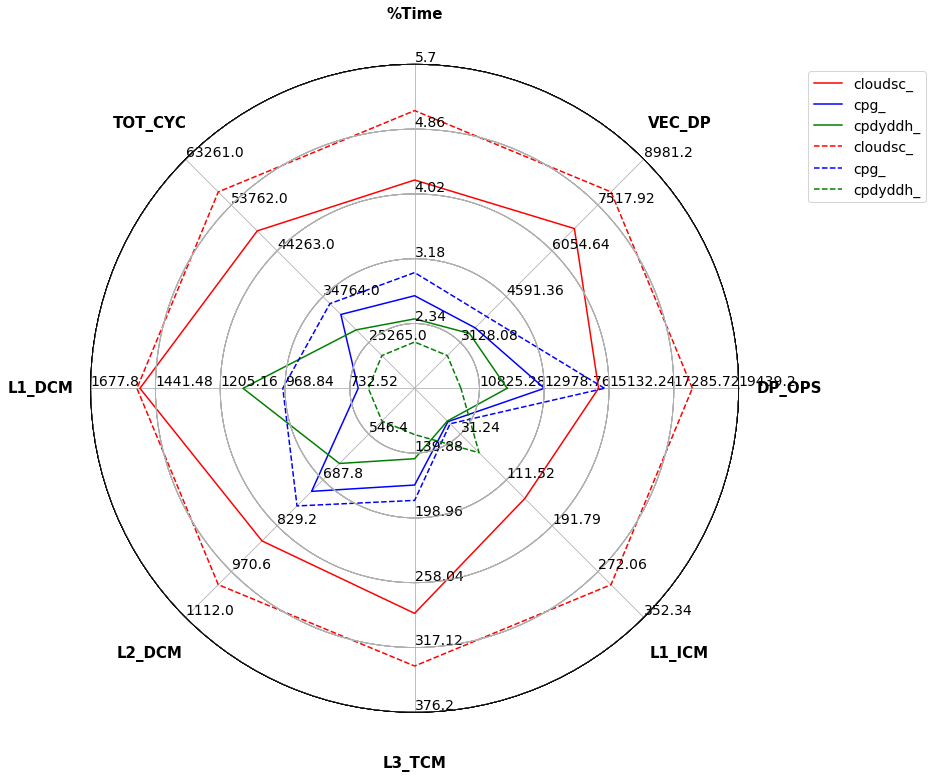

In [66]:
functions_to_plot = ['cloudsc_', 'cpg_', 'cpdyddh_']
data2 = data.loc[data['Function'].isin(functions_to_plot)]
data_source2_2 = data_source2.loc[data_source2['Function'].isin(functions_to_plot)]

labels = ['DP_OPS', 'VEC_DP', '%Time', 'TOT_CYC', 'L1_DCM', 'L2_DCM', 'L3_TCM', 'L1_ICM']
    
fig1 = plt.figure(figsize=(10, 10));
radar = ComplexRadar(fig1, labels, [data_source2_2, data2], functions_to_plot);
radar.plot().figure.savefig('fig.png');



In [54]:
import plotly.graph_objects as go
import pandas as pd
import plotly.express as px

functions_to_plot = ['cloudsc_', 'cpg_', '__read_nocancel']

df = pd.read_csv("ecprof_papi_crayhopt.csv")
import json
import pprint
import pandas as pd

parsed_dict = dict()
pp = pprint.PrettyPrinter(indent=3)

with open("callgraph.json") as f:
    for i in data.keys():
        for j in data[i]:
            name = j
            if j not in parsed_dict:
                parsed_dict[name] = {}
                # name scope and file
            if name == i:
                parsed_dict[name]['parent'] = None
            else:
                parsed_dict[name]['parent'] = i


df_parents = pd.DataFrame.from_dict(parsed_dict).transpose()
df = df.loc[df["Function"].isin(functions_to_plot)]
df_parents = df_parents.loc[df_parents.index.isin(functions_to_plot) & df_parents.parent.isin(functions_to_plot)]
df = df.set_index('Function').join(df_parents).fillna('').reset_index()

primary_feature = 'WallTime'
features = ['Function',"WallTime", 'parent']

df = df[features]
df = df.to_dict()
df_new = {}
for i in df.keys():
    if i == "Function":
        df_new['function_name'] = list(df[i].values())
    elif i == "WallTime":
        df_new['value'] = list(df[i].values())
    else:
        df_new['parent'] = list(df[i].values())
fig =px.sunburst(
    df_new,
    names='function_name',
    parents='parent',
    values='value',
)

fig.update_layout(width=600,
    height=600,uniformtext=dict(minsize=3, mode='show'))
fig.show()


In [19]:
# Export the drawn figures to html objects that are going to be used in the React app
import plotly
plotly.io.orca.config.executable = '/usr/local/bin/orca'


In [7]:

data = pd.read_csv("example_omp18_papi.csv")
data1 = pd.read_csv("example_omp1_papi.csv")
data = data[['Function', '#Hits']].head(20)
display(data)
fig = px.pie(data, values='#Hits', names='Function', title='Number of cache Hits')
fig.show()


,Function,#Hits
0,save_fluxes,118
1,solver_mcica_lw,112
2,rrtm_taumol3,107
3,solver_homogeneous_sw,78
4,rrtm_kgb7,56
5,solver_homogeneous_lw,52
6,fast_expm_exchange_2,41
7,rrtm_taumol5,28
8,get_real_matrix_indexed,28
9,calc_ice_optics_fu_lw,27


In [ ]:


# hard to do the ifs performance
# it does not play well with comercial available
# also it is hard to understand the data from DrHook
# we need compositions


# talk about the 3 usecases
# talk about the phisycs one
# click on the metrics

###########################
###                     ###
###        DEMO         ###
###                     ###
###########################

# first simple select
# second one is mergeing the performance in multiple compiler caracts in the same
# third one is comparing multiple subrutines in a single spiderweb
# so getting 2 selectors 


# select the labels as well in another selector
# and the way the labels are working are the other way aroung this meaning that 
# leaf: [all of the parents]
# the structure is like this : leaf: call stack


#####################
#   roots selector  #
#####################

######################
#   depth selector   #
######################


# check the OMP-PHYSICS

# CLOUD_SC

# then get a new spider web on
# do then the copy paste and the spider web intertwine
# change the colors in the spiderweb
# compare the way that
# one idea is to compare 2 functions


# the second one is going to be comparing 2 compilers

# the end prototype agile configurable
# the performance analytics be easyer
# better at the job

In [49]:
# graph plots
import plotly.graph_objects as go
import pandas as pd
import plotly.express as px
import json
import pprint
import pandas as pd
import networkx as nx
import random
from collections import defaultdict

parsed_dict = defaultdict(dict)
nodes = set()
edges = []
pos = None
dim = 2
seed = None
depth = 1

old = 'MASTER' 
labels = []

with open("callgraph.json") as f:
    data = json.load(f)
    for i in data.keys():
        for j in data[i]:
            if old != None:
                parsed_dict[old]['parent'] = j
                parsed_dict[old]['depth'] = len(data[i]) - 1
                parsed_dict[old]['finalParent'] = data[i][-1]
            old = j
        labels.append(data[i][-1])
        parsed_dict[data[i][-1]]['parent'] = 'MASTER'
        parsed_dict[data[i][-1]]['depth'] = 0
        parsed_dict[old]['finalParent'] = data[i][-1]
        
        
        # The last is the top level
        # so it has no parent
        # but also it is a label
        old =  'MASTER' 

parsed_dict = dict(parsed_dict)

In [52]:
# START get depth of the data
depth = 4
data = list(filter(lambda x: parsed_dict[x]['finalParent'] == 'MASTER' and
                   parsed_dict[x]['depth'] < 4,
                     parsed_dict.keys()))
newData = set(data)
# for i in data:
#     newData.add(parsed_dict[i]['parent'])
for i in newData:
    local_depth = depth
    parent = parsed_dict[i]['parent']
    local = i
    if parent == None or i == None:
        continue

    while local_depth >= 0:
        edges.append((local, parent))
        if i in newData or parent in newData:
            nodes.add(i)
            nodes.add(parent)
        if i:
            parent = parsed_dict[i]['parent']
        else:
            edges.append((local, ''))
            nodes.add(i)
            nodes.add(parent)
            nodes.add('SourceOfGraph')
            break
        local_depth -= 1
            
# END get depth of the data
            
G = nx.Graph()
G.add_nodes_from(list(nodes))
pos = {v: [random.randint(0, len(edges)) for i in range(dim)] for v in nodes} # TODO this is not good in here 
nx.set_node_attributes(G, pos, "pos")

G.add_edges_from(edges)

edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    mode='lines')
node_x = []
node_y = []
for node in nodes:
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)


node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(line_width=2))

node_adjacencies = []
node_text = []
for node in G.nodes():
    node_text.append(node)

node_trace.text = node_text

fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                titlefont_size=16))
fig.show()